# Introduction

In this project, we will attempt to greate a Generative Adversarial Network (GAN) in order to manipulate facial expressions.

Our first step is to load the neccessary libraries we will be using for the entire process.

In [1]:
#Loading the neccessary libraries
%matplotlib inline
import os
import cv2
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

from skimage import io
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

We will now create a variable which points to our local directory. We create these variables as shortcut so we will not have to type the entire directory everytime needed. Take note that the image dataset/directory is located in a different folder than the python notebook files.

In [2]:
#Create Folder Paths to shorten directory
landmark = Path('''E:\Data_Cloud\GoogleDrive\Dataset\Landmark''')
wild = Path('''E:\Data_Cloud\GoogleDrive\Dataset\wild''')
crop_utkface = Path('''E:\Data_Cloud\GoogleDrive\Dataset\Crop''')

There are two landmark directories with 3 files in them and an image folder with two subdirectories namely crop_part1 and the UTKFace directory. In this next section, we will attempt to view the files. The landmark folders will be assigned to a dataframe and the images folder will be set up to view what some of the images may appear to be.

In [3]:
#Creating a dataframe for each of the landmark text files.
landmark1 = pd.read_csv(landmark/'landmark_list_part1.txt',header=None)
landmark2 = pd.read_csv(landmark/'landmark_list_part2.txt', header=None)
landmark3 = pd.read_csv(landmark/'landmark_list_part3.txt',header=None)

#Merging the 3 dataframes into one.
landmark_frame = pd.concat([landmark1, landmark2, landmark3])

With the second directory containing landmark files as well, we will also create a separate dataframe for each files, then merge them into one dataframe.

In [4]:
#Creating 3 dataframs for each of the files.
wild1 = pd.read_csv(wild/'landmark_list_part1.txt',header=None)
wild2 = pd.read_csv(wild/'landmark_list_part2.txt',header=None)
wild3 = pd.read_csv(wild/'landmark_list_part3.txt',header=None)

#Merging the three dataframes into one.
wild_frame = pd.concat([wild1, wild2, wild3])

### Exploring the Images in the Data Folder

Next, we will attempt to view what the images looks like in each of the two image folders. In the initial folder, crop_part1, we will pull 5 random images and observe how they appear.

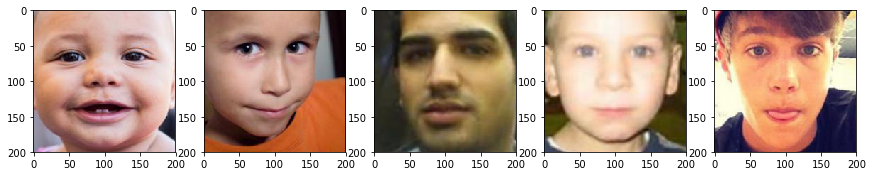

In [5]:
plt.figure(figsize=(30,30))

crop_folder = crop_utkface/'crop_part1'

for i in range(5):
    file = np.random.choice(os.listdir(crop_folder))
    image_path= os.path.join(crop_folder, file)
    image=mpimg.imread(image_path)
    plt.subplot(1,10,i+1)
    plt.imshow(image)

We will attempt the same procedure to the 'UTKFace' folder, but instead of getting several images, we will get one random images, then observe as we did previously.

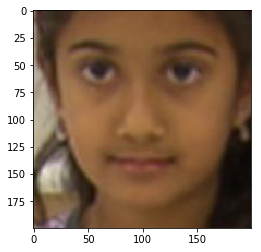

In [6]:
UTKFace_folder = crop_utkface/'UTKFace'

for i in range(1):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path = os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.imshow(image)

### Creation of a Python class

We will not create a class in order to pull images from the dataset. Unlike the previous precedures, we will not only view the dataset, but assign a class which we may use several times throughout. This class shall make it easier to load images and will be useful when creating the model at a later point.

In [7]:
#Creata a class to pull items from the image folder
class FaceDataset(Dataset):
    def __init__(self, main, transform=None):
        self.main = main
        images = os.listdir(main)
        self.all_images = glob.glob(os.path.join(main, '*.jpg'))
        self.transform=transform
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.main, self.all_images[index])
        image = io.imread(img_loc)
        if self.transform is not None:
            image=Image.fromarray(image.astype('uint8'), 'RGB')
            image=self.transform(image)
        return image

In [8]:
trans = transforms.Compose([
        transforms.Resize(200, 200),
        transform.RandomResizedCrop([200,200]),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        #transforms.ToTensor(),
        ]) 

In [9]:
eval_trans = transforms.Compose([
        transforms.Resize(200, 200),
        #transform.RandomResizedCrop([200,200]),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        #transforms.ToTensor(),
        ]) 

### Variable asignment and image viewing

We now create a variable which will run the class on a specific folder. We will create two variable assignments which will be assigned to the two datasets that was provided with.

There are 9787 images in the crop_part1 folder


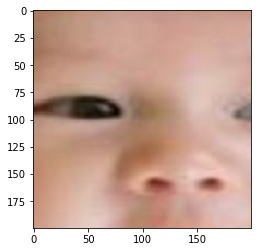

In [10]:
#Crearting a variable with the class and the crop_part1 folder
facedata_crop = FaceDataset(crop_folder, transform=trans)
print('There are {} images in the crop_part1 folder'.format(len(facedata_crop)))

#retreiving an specific image for observations. Image number 1573
plt.imshow(facedata_crop[1573])
plt.show()

There are 23708 images in the UTKFace folder


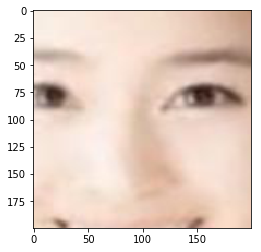

In [11]:
#Crearting a variable with the class and the UTKFace Folder
facedata_UTKFace = FaceDataset(UTKFace_folder, transform=trans)
print('There are {} images in the UTKFace folder'.format(len(facedata_UTKFace)))

#retreiving an specific image for observations. Image number 3997
plt.imshow(facedata_UTKFace[3997])
plt.show()

### Analysis of Image Data

We will now further analyze the image data by looking at its raw data. Using the image 1072 of the crop folder, we display the data as a numpy array.

We will also look into the shape of some sample images, the image properties of the first image shown above are as follows. 200, 200 and 3 channels

In [12]:
#print('The shape of the image is: {}'.format(facedata_crop[1573].shape))
#print('The size of the image is: {}'.format(facedata_crop[1573].size))
print('The data type of the image is: {}'.format(type(facedata_crop[1573])))

The data type of the image is: <class 'PIL.Image.Image'>


The image properties of the second image shown above are as follows

In [13]:
#print('The shape of the image is: {}'.format(facedata_UTKFace[3997].shape))
#print('The size of the image is: {}'.format(facedata_UTKFace[3997].size))
#print('The data type of the image is: {}'.format(facedata_UTKFace[3997].dtype))

It seems like the image properties on both these randomly selected images has the same properties and attributes.

In [14]:
crop_dataloader = DataLoader(facedata_crop, batch_size=128, shuffle=False, sampler=None,
                             batch_sampler=None, num_workers=4, collate_fn=None,
                             pin_memory=True, drop_last=False, timeout=0, worker_init_fn=None)

In [15]:
utk_dataloader = DataLoader(facedata_UTKFace, batch_size=1, shuffle=False, sampler=None,
                             batch_sampler=None, num_workers=0, collate_fn=None,
                             pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)

#### Initilizing the GPU

Will now initialize the device to be using the GPU for quicker training.

In [16]:
#Checking if the correct gpu drivers have been installed
torch.cuda.is_available()

True

In [17]:
#Setting the device to GPU on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
#### Noise Generartion for Vector
noise = torch.randn(128, 100, 1, 1,  device=None)

#### Greate the Generator

In [19]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        
        #layer 1
        nn.ConvTranspose2d(100, 64*32, kernel_size=4, stride=1, padding=0, 
                           bias=False),
        nn.BatchNorm2d(64*16),
        nn.ReLU(True),
        
        #Layer 2
        nn.ConvTranspose2d(64*32, 64*16, kernel_size=4, stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),
        
        #Layer 3
        nn.ConvTranspose2d(64*16, 64*8, kernel_size=4, stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(64*4),
        nn.ReLU(True),
        
        #Layer 4    
        nn.ConvTranspose2d(64*8, 64*4,kernel_size=4, stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(64*2),
        nn.ReLU(True),
        
        #Layer 5
        nn.ConvTranspose2d(100, 64, kernel_size=4, stride=2, padding=1, 
                           bias=False),
        nn.Tanh(True)
            
        )
        
    def forward(self, input):
        
        return self.main(input)

In [20]:
# # Create the generator
# netG = Generator(ngpu).to(device)

# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# print(netG)

#### Create the Discriminiator

In [21]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            
            #Layer 1
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1,
                     bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            #Layer 2
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1,
                     bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            #Layer 3
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1,
                     bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            #Layer 4
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1,
                     bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            #Laye 5
            nn.Conv2d(64*8, 1, kernel_size=4, stride=2, padding=1,
                     bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        
        return self.main(input)

#### Creating an optimizers

In [22]:
generator = Generator()
discriminator = Discriminator()

optimizer_gen = torch.optim.Adam(generator.parameters())
optimazer_disc = torch.optim.Adam(discriminator.parameters())

TypeError: __init__() missing 1 required positional argument: 'ngpu'

#### Update Functions

In [26]:
#Update the Generator
def update_generator():
    
    noise = 
    generate_samples =
    prob_fake =
    
    loss =
    
    #Gradient Step
    
    return

SyntaxError: invalid syntax (<ipython-input-26-d46efd260109>, line 4)

In [ ]:
#Update Discriminator
def update_discriminator():
    
    real_samples =
    prob_real =
    
    noise =
    genereted_samples =
    prob_fake = 
    
    loss = 
    return

In [ ]:
def loss_function():
    
    return

In [ ]:
#training loop